In [17]:
import os
from typing import TypedDict
from typing import Dict, List, Tuple, Annotated
from langgraph.graph import StateGraph
from langsmith import traceable
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.constants import START, END
from langchain_groq import ChatGroq
from pydantic import BaseModel
from typing import Optional, Any
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv()

# Initialize LLM
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen-2.5-32b")

In [18]:
# Define the states
@dataclass
class BlogState:
    topic: Optional[str] = None
    outline: Optional[str] = None
    draft: Optional[str] = None
    edited_draft: Optional[str] = None

In [22]:
# Define the nodes (functions)
def select_topic(state: BlogState):
    prompt = ChatPromptTemplate.from_template("Suggest a blog topic: {user_request}")
    chain = prompt | llm | StrOutputParser()
    topic = chain.invoke({"user_request": "Suggest a popular and interesting blog topic."})
    return {"topic": topic}

def generate_outline(state: BlogState):
    prompt = ChatPromptTemplate.from_template("Generate an outline for a blog about: {topic}")
    chain = prompt | llm | StrOutputParser()
    outline = chain.invoke({"topic": state.topic})
    return {"outline": outline}

def draft_content(state: BlogState):
    prompt = ChatPromptTemplate.from_template("Write a blog draft based on the following outline: {outline}")
    chain = prompt | llm | StrOutputParser()
    draft = chain.invoke({"outline": state.outline})
    return {"draft": draft}

def review_and_edit(state: BlogState):
    prompt = ChatPromptTemplate.from_template("Review and edit the following blog draft: {draft}")
    chain = prompt | llm | StrOutputParser()
    edited_draft = chain.invoke({"draft": state.draft})
    return {"edited_draft": edited_draft}

In [23]:
def publishing(state: BlogState):
    print(f"Final Blog Draft: \n{state.edited_draft}")
    return {}

In [24]:
# Define the graph
workflow = StateGraph(BlogState)
workflow.add_node("topic_selection", select_topic)
workflow.add_node("outline_generation", generate_outline)
workflow.add_node("draft_content", draft_content)
workflow.add_node("review_and_edit", review_and_edit)
workflow.add_node("publishing", publishing)

In [25]:
# Define the edges
workflow.add_edge("topic_selection", "outline_generation")
workflow.add_edge("outline_generation", "draft_content")
workflow.add_edge("draft_content", "review_and_edit")
workflow.add_edge("review_and_edit", "publishing")
workflow.set_entry_point("topic_selection")

In [27]:
chain = workflow.compile()

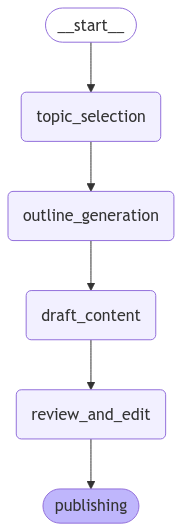

In [28]:
from IPython.display import Image, display
display(Image(chain.get_graph().draw_mermaid_png()))

In [29]:
BlogState=chain.invoke({"topic":"Blockchain"})

Final Blog Draft: 
Your blog draft is well-structured and covers a broad spectrum of topics relevant to the future of work. Here are some suggestions to refine and enhance your draft:

### The Future of Work: How Technology is Reshaping Careers

#### Introduction
The concept of work has always been in flux, driven by technological advancements that redefine operations, collaboration, and innovation. This blog post explores the transformative impact of technology on careers, a trend that is not only inevitable but also profoundly transformative. Understanding these changes is critical for employers and employees as they navigate the evolving job market landscape.

#### Section 1: The Technological Revolution in Context
The current technological revolution, characterized by rapid advancements in artificial intelligence (AI), automation, and remote work technologies, is a continuation of a historical pattern of technological evolution that has reshaped work environments from the Industria

In [30]:
BlogState

{'topic': 'A popular and interesting blog topic could be "The Future of Work: How Technology is Reshaping Careers." This topic can delve into the impacts of technological advancements like AI, automation, and remote work technologies on the job market, career development, and workplace dynamics. It\'s a relevant and engaging subject as many people are curious about how these changes will affect their future employment and daily work lives.',
 'outline': '### Blog Outline: The Future of Work: How Technology is Reshaping Careers\n\n#### Introduction\n- Briefly introduce the concept of the future of work.\n- Mention the role of technology in reshaping careers and the importance of understanding these changes.\n\n#### Section 1: Understanding the Current Technological Revolution\n- Overview of current technological advancements (AI, automation, remote work technologies).\n- Historical context: How past technological revolutions have reshaped work.\n- The inevitability of technological chan